## Batched Gradients

In [1]:
using Pkg
Pkg.activate(".")
using LaplaceRedux
using LaplaceRedux.Curvature
using LaplaceRedux.Data
using Flux
using Flux.Optimise: update!, Adam
using Plots
using Statistics
using MLUtils
using Zygote
using Printf
using NNlib
using BenchmarkTools
using Tullio

  Activating project at `~/Builds/navimakarov/LaplaceRedux.jl/dev/notebooks/batching`


In [2]:
# Setup some dummy data, like in tests

n = 128
data_dict = Dict()
bsize = 2

x, y = LaplaceRedux.Data.toy_data_regression(n)
xs = [[x] for x in x]
X, Y = reduce(hcat, x), reduce(hcat, y)

dataloader = DataLoader((X, Y), batchsize=bsize)
data = zip(xs, y)
data_dict[:regression] = Dict(
    :data => data,
    :X => X,
    :y => y,
    :outdim => 1,
    :loss_fun => :mse,
    :likelihood => :regression,
)

Dict{Symbol, Any} with 6 entries:
  :loss_fun   => :mse
  :y          => [-0.663368, -0.571399, 0.918833, 1.14956, 0.946187, -0.941379,…
  :likelihood => :regression
  :X          => [4.10628 6.01095 … 1.05544 3.88312]
  :outdim     => 1
  :data       => zip([[4.10628], [6.01095], [1.59898], [2.24793], [6.96247], [5…

In [3]:
# Train a NN model

val = data_dict[:regression]

# Unpack:
data = val[:data]
X = val[:X]
y = val[:y]
outdim = val[:outdim]
loss_fun = val[:loss_fun]
likelihood = val[:likelihood]

# Neural network:
n_hidden = 32
D = size(X, 1)
nn = Chain(Dense(D, n_hidden, σ), Dense(n_hidden, outdim))
λ = 0.01
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1 / 2 * λ^2 * sum(sqnorm, Flux.params(nn))
loss(x, y) = getfield(Flux.Losses, loss_fun)(nn(x), y) + weight_regularization()


opt = Adam()
epochs = 200
avg_loss(data) = mean(map(d -> loss(d[1], d[2]), data))
show_every = epochs / 10

for epoch in 1:epochs
    for d in data
        gs = gradient(Flux.params(nn)) do
            l = loss(d...)
        end
        update!(opt, Flux.params(nn), gs)
    end
    if epoch % show_every == 0
        println("Epoch " * string(epoch))
        @show avg_loss(data)
    end
end


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 32, σ)   # 64 parameters
│   summary(x) = "1-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


Epoch 20
avg_loss(data) = 0.5012021203338505
Epoch 40
avg_loss(data) = 0.4787572448554173
Epoch 60
avg_loss(data) = 0.46190194585368055
Epoch 80
avg_loss(data) = 0.4456237311815436
Epoch 100
avg_loss(data) = 0.42800408570513887
Epoch 120
avg_loss(data) = 0.408482606816268
Epoch 140
avg_loss(data) = 0.387314712770891
Epoch 160
avg_loss(data) = 0.3638712785423623
Epoch 180
avg_loss(data) = 0.3376305202966803
Epoch 200
avg_loss(data) = 0.308579478762796


In [8]:
model = nn

Chain(
  Dense(1 => 32, σ),                    # 64 parameters
  Dense(32 => 1),                       # 33 parameters
)                   # Total: 4 arrays, 97 parameters, 644 bytes.

In [9]:
# Loss fun for regression
loss_fn(x, ytrue; agg=sum) = Flux.Losses.mse(model(x), ytrue, agg=agg)

loss_fn (generic function with 1 method)

In [4]:
dataloader

64-element DataLoader(::Tuple{Matrix{Float64}, Matrix{Float64}}, batchsize=2)
  with first element:
  (1×2 Matrix{Float64}, 1×2 Matrix{Float64},)

In [5]:
# Take one datapoint of the dataset
x_1 = xs[1]
y_1 = y[1]

-0.6633678850542059

In [10]:
grads_1 = gradient(() -> loss_fn(x_1, y_1), Flux.params(model))
grads = grads_1

Grads(...)

In [11]:
grads.grads

IdDict{Any, Any} with 6 entries:
  Float32[0.224212; -0.229… => Float32[0.215939; -0.338643; … ; 0.379741; -0.36…
  :(Main.y_1)               => -0.728207
  :(Main.x_1)               => Float32[-0.0396047]
  Float32[-0.45999, 0.4075… => Float32[0.0525876, -0.0824695, 0.0772545, 0.0701…
  Float32[0.30446 -0.48626… => Float32[0.44652 0.268871 … 0.450342 0.268706]
  Float32[-0.0663767]       => Float32[0.728207]

In [12]:
grads.params

Params([Float32[0.2242121; -0.22966594; … ; 0.2254382; -0.22922081;;], Float32[-0.45998955, 0.40752098, 2.0472596, 1.327311, -0.43800884, 0.3686145, 0.34820905, 1.5097885, -0.45043552, -0.36027348  …  1.292601, 0.4150695, 2.0421948, -0.3785736, 0.32690892, -0.7591509, -0.3376909, 1.9202763, -0.4428397, 0.40472198], Float32[0.30446014 -0.4862661 … 0.5381678 -0.5297157], Float32[-0.06637672]])

In [13]:
length(grads.params)

4

In [14]:
sum(length, grads.params) # 97 params total

97

In [15]:
fieldnames(Params)

(:order, :params)

In [16]:
grads.params.order

Zygote.Buffer{Any, Vector{Any}}(Any[Float32[0.2242121; -0.22966594; … ; 0.2254382; -0.22922081;;], Float32[-0.45998955, 0.40752098, 2.0472596, 1.327311, -0.43800884, 0.3686145, 0.34820905, 1.5097885, -0.45043552, -0.36027348  …  1.292601, 0.4150695, 2.0421948, -0.3785736, 0.32690892, -0.7591509, -0.3376909, 1.9202763, -0.4428397, 0.40472198], Float32[0.30446014 -0.4862661 … 0.5381678 -0.5297157], Float32[-0.06637672]], false)

In [17]:
th_1 = grads.params[1]

32×1 Matrix{Float32}:
  0.2242121
 -0.22966594
 -0.88409716
 -0.72190404
  0.22454381
 -0.22676444
 -0.22678824
 -0.7612891
  0.22296886
  0.21973221
  0.22445358
 -0.22559594
 -0.22920309
  ⋮
 -0.2284222
 -0.22852248
 -0.7150127
 -0.22874163
 -0.8828031
  0.21975312
 -0.226349
  0.6031544
  0.21385738
 -0.85410285
  0.2254382
 -0.22922081

In [18]:
# This is the gradient of the loss function value at (x_1, y_1) for th_1
# Size 32
grads.grads[th_1]

32×1 Matrix{Float32}:
  0.21593948
 -0.33864307
  0.31722873
  0.28823042
  0.30097228
 -0.49963722
 -0.37087613
  0.30121154
  0.18767184
  0.22395624
  0.39562792
 -0.25909066
 -0.3725306
  ⋮
 -0.34810314
 -0.3907495
  0.15767112
 -0.50923836
  0.40007943
  0.19183882
 -0.3306854
 -0.07639467
  0.2095592
  0.440717
  0.3797413
 -0.3688083

In [19]:
# The same for x_2, y_2
x_2 = xs[2]
y_2 = y[2]
grads_2 = gradient(() -> loss_fn(x_2, y_2), Flux.params(model))
grads_2.grads[th_1]

32×1 Matrix{Float32}:
  0.4335996
 -0.6673518
  0.18305863
  0.21782224
  0.6015094
 -0.9821071
 -0.72623146
  0.21368295
  0.37689304
  0.44457337
  0.7880242
 -0.50159574
 -0.7343564
  ⋮
 -0.68400735
 -0.76939917
  0.12040265
 -1.006497
  0.23141131
  0.38207862
 -0.6454727
 -0.069546595
  0.41818124
  0.26784256
  0.7585486
 -0.7269415

In [20]:
# Now take one batch combining the two
x_b, y_b = popfirst!(Iterators.Stateful(dataloader))

([4.106280607376283 6.010951579134826], [-0.6633678850542059 -0.5713989294786477])

In [21]:
@show x_1
@show x_2
@show y_1
@show y_2

x_1 = [4.106280607376283]
x_2 = [6.010951579134826]
y_1 = -0.6633678850542059
y_2 = -0.5713989294786477


-0.5713989294786477

In [39]:
# Take the *Jacobian* to obtain the gradients for the batch parts
grads_b = jacobian(() -> loss_fn(x_b, y_b, agg=identity), Flux.params(model))

Grads(...)

In [40]:
grads_b.grads[th_1]

2×32 Matrix{Float64}:
 0.215939  -0.338643  0.317229  0.28823   …  0.440717  0.379741  -0.368808
 0.4336    -0.667352  0.183059  0.217822     0.267843  0.758549  -0.726942

In [41]:
th = grads_b.params

Params([Float32[0.2242121; -0.22966594; … ; 0.2254382; -0.22922081;;], Float32[-0.45998955, 0.40752098, 2.0472596, 1.327311, -0.43800884, 0.3686145, 0.34820905, 1.5097885, -0.45043552, -0.36027348  …  1.292601, 0.4150695, 2.0421948, -0.3785736, 0.32690892, -0.7591509, -0.3376909, 1.9202763, -0.4428397, 0.40472198], Float32[0.30446014 -0.4862661 … 0.5381678 -0.5297157], Float32[-0.06637672]])

In [42]:
grads_b.params == grads_1.params == grads_2.params

true

In [26]:
grads_b[th_1]

2×32 Matrix{Float64}:
 0.215939  -0.338643  0.317229  0.28823   …  0.440717  0.379741  -0.368808
 0.4336    -0.667352  0.183059  0.217822     0.267843  0.758549  -0.726942

In [43]:
grads

Grads(...)

In [104]:
grads_1[th_1]'

1×32 adjoint(::Matrix{Float32}) with eltype Float32:
 0.215939  -0.338643  0.317229  0.28823  …  0.440717  0.379741  -0.368808

In [100]:
grads_2[th_1]'

1×32 adjoint(::Matrix{Float32}) with eltype Float32:
 0.4336  -0.667352  0.183059  0.217822  …  0.267843  0.758549  -0.726942

In [28]:
# grads_1 .* transpose.(grads_1)

In [101]:
sum(length, grads_1)

97

In [102]:
sum(length, grads_1.params)

97

In [103]:
sum(length, grads_b)

194

In [44]:
# We would like to obtain g as a 97x2 matrix
# containing as the first column the gradient for loss_fn(x_1, y_1) wrt theta (of size 97)
# and as the second column, one for loss_fn(x_2, y_2)
g = permutedims(reduce(hcat, grads_b))

97×2 Matrix{Float64}:
  0.215939   0.4336
 -0.338643  -0.667352
  0.317229   0.183059
  0.28823    0.217822
  0.300972   0.601509
 -0.499637  -0.982107
 -0.370876  -0.726231
  0.301211   0.213683
  0.187672   0.376893
  0.223956   0.444573
  0.395628   0.788024
 -0.259091  -0.501596
 -0.372531  -0.734356
  ⋮         
  0.267246   0.31292
  0.117968   0.054124
  0.270798   0.31761
  0.124082   0.0422294
  0.457339   0.825363
  0.257612   0.300948
  0.617385   1.08526
  0.460169   0.826622
  0.123663   0.0443363
  0.450342   0.818352
  0.268706   0.314581
  0.728207   1.14702

In [94]:
function gradient_helper(model, x, y)
    grads = jacobian(() -> loss_fn(x, y, agg=identity), Flux.params(model))
    g = permutedims(reduce(hcat, grads))
end

gradient_helper (generic function with 1 method)

In [105]:
# sanity check
grads_b[th[1]]

2×32 Matrix{Float64}:
 0.215939  -0.338643  0.317229  0.28823   …  0.440717  0.379741  -0.368808
 0.4336    -0.667352  0.183059  0.217822     0.267843  0.758549  -0.726942

In [106]:
grads_b[th[length(th)-1]]

2×32 Matrix{Float64}:
 0.44652   0.268871  0.124056   0.118603   …  0.123663   0.450342  0.268706
 0.812573  0.314609  0.0421191  0.0537788     0.0443363  0.818352  0.314581

In [107]:
grads_b[th[length(th)]] # sanity: checked

2×1 Matrix{Float64}:
 0.7282071113586426
 1.147015929222107

In [108]:
vg = g * transpose(g)

97×97 Matrix{Float64}:
  0.234638   -0.36249     0.147876   …   0.452084    0.194426    0.654594
 -0.36249     0.560037   -0.229592      -0.698634   -0.300932   -1.01207
  0.147876   -0.229592    0.134145       0.292668    0.142828    0.440979
  0.156688   -0.242971    0.131309       0.308058    0.145972    0.459737
  0.325806   -0.503341    0.205589       0.627787    0.270097    0.909111
 -0.533733    0.82461    -0.338282   …  -1.02872    -0.443208   -1.49033
 -0.39498     0.610246   -0.250595      -0.761334   -0.328115   -1.10307
  0.157696   -0.244605    0.134669       0.310516    0.148158    0.464442
  0.203946   -0.315074    0.128528       0.392948    0.168992    0.568966
  0.241128   -0.372528    0.152428       0.464675    0.200033    0.673019
  0.427119   -0.659866    0.269759   …   0.823049    0.354205    1.19198
 -0.27344     0.42248    -0.174012      -0.527161   -0.227412   -0.76401
 -0.398861    0.616229   -0.252608      -0.768729   -0.331116   -1.1136
  ⋮                   

In [109]:
foreach(x -> @show(size(x)), grads)

size(x) = (32, 1)
size(x) = (32,)
size(x) = (1, 32)
size(x) = (1,)


In [110]:
g_1 = reduce(vcat, [vec(grads_1[th]) for th in grads_1.params])
g_2 = reduce(vcat, [vec(grads_2[th]) for th in grads_2.params])
# let v(g) denote gg'
vg_1 = g_1 * transpose(g_1)
vg_2 = g_2 * transpose(g_2)

97×97 Matrix{Float32}:
  0.188009   -0.289363    0.0793741   …   0.354837    0.136402    0.497346
 -0.289363    0.445358   -0.122165       -0.546129   -0.209936   -0.765463
  0.0793741  -0.122165    0.0335105       0.149806    0.0575868   0.209971
  0.0944476  -0.145364    0.0398742       0.178255    0.0685228   0.249846
  0.260814   -0.401418    0.110111        0.492247    0.189223    0.689941
 -0.425841    0.655411   -0.179783    …  -0.80371    -0.308952   -1.12649
 -0.314894    0.484652   -0.132943       -0.594313   -0.228459   -0.832999
  0.0926528  -0.142602    0.0391165       0.174868    0.0672206   0.245098
  0.163421   -0.25152     0.0689935       0.308431    0.118563    0.432302
  0.192767   -0.296687    0.081383        0.363818    0.139854    0.509933
  0.341687   -0.525889    0.144255    …   0.644881    0.247898    0.903876
 -0.217492    0.334741   -0.0918214      -0.410482   -0.157793   -0.575338
 -0.318417    0.490074   -0.13443        -0.600962   -0.231015   -0.842318
  ⋮

In [111]:
isapprox(vg_1 + vg_2, vg, atol=.0005) 
# This is not it.
# We want a 97x97x2 matrix

true

In [112]:
# Reshape g as 97x1x2 since MLUtils expects 3-d arrays
gm = reshape(g, size(g, 1), 1, size(g, 2))

97×1×2 reshape(transpose(::Matrix{Float64}), 97, 1, 2) with eltype Float64:
[:, :, 1] =
  0.2159394472837448
 -0.33864301443099976
  0.3172287046909332
  0.28823038935661316
  0.30097222328186035
 -0.4996371567249298
 -0.3708760738372803
  0.3012114465236664
  0.18767179548740387
  0.22395619750022888
  0.39562785625457764
 -0.2590906322002411
 -0.3725305497646332
  ⋮
  0.267246276140213
  0.11796755343675613
  0.2707975506782532
  0.12408159673213959
  0.45733925700187683
  0.2576119899749756
  0.6173853278160095
  0.4601694941520691
  0.12366347759962082
  0.45034223794937134
  0.2687060832977295
  0.7282071113586426

[:, :, 2] =
  0.433599591255188
 -0.6673517823219299
  0.18305863440036774
  0.21782223880290985
  0.6015093922615051
 -0.9821071028709412
 -0.7262314558029175
  0.21368294954299927
  0.3768930435180664
  0.44457337260246277
  0.7880241870880127
 -0.5015957355499268
 -0.7343564033508301
  ⋮
  0.31291961669921875
  0.05412396043539047
  0.3176100254058838
  0.04222935810

In [44]:
vgm = batched_mul(gm, batched_transpose(gm))

LoadError: UndefVarError: `gm` not defined

In [45]:
@assert isapprox(vgm[:,:,1], vg_1, atol=.0005)
@assert isapprox(vgm[:,:,2], vg_2, atol=.0005)

LoadError: UndefVarError: `vgm` not defined

In [46]:
vg_2

LoadError: UndefVarError: `vg_2` not defined

In [47]:
g

LoadError: UndefVarError: `g` not defined

In [48]:
# Now try einsums
using Tullio

In [49]:
@tullio H[i, j, b] := g[i, b] * g[j, b]

LoadError: UndefVarError: `g` not defined

In [50]:
@assert isapprox(vgm, H, atol=eps())

LoadError: UndefVarError: `vgm` not defined

In [51]:
eps()

2.220446049250313e-16

## Benchmarks for batched computation of H = 𝐠 * 𝐠'

In [52]:
using BenchmarkTools

In [86]:
# Method 1: reshape + MLUtils
function method_1(g)
    gm = reshape(g, size(g, 1), 1, size(g, 2))
    vgm = batched_mul(gm, batched_transpose(gm))
end

method_1 (generic function with 1 method)

In [87]:
# Method 2: Tullio Einstein summation
function method_2(g)
    @tullio H[i, j, b] := g[i, b] * g[j, b]
end

method_2 (generic function with 1 method)

In [88]:
@benchmark method_1($g)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  54.134 μs …   4.024 ms  ┊ GC (min … max):  0.00% … 92.88%
 Time  (median):     58.490 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   76.993 μs ± 237.903 μs  ┊ GC (mean ± σ):  20.27% ±  6.43%

    ▇▅▂█▃▁                                                      
  ▁▂██████▆▅▅▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  54.1 μs         Histogram: frequency by time         97.9 μs <

 Memory estimate: 209.38 KiB, allocs estimate: 18.

In [89]:
@benchmark method_2($g)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  18.267 μs …   3.831 ms  ┊ GC (min … max):  0.00% … 98.41%
 Time  (median):     20.120 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   31.827 μs ± 200.458 μs  ┊ GC (mean ± σ):  35.24% ±  5.55%

         ▃▆█▇▄▁                                                 
  ▁▁▁▁▂▄▇██████▆▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  18.3 μs         Histogram: frequency by time         29.3 μs <

 Memory estimate: 147.12 KiB, allocs estimate: 2.

In [95]:
# More benchmarks:
# batchsize = 128
dataloader_128 = DataLoader((X, Y), batchsize=128)
x_128, y_128 = popfirst!(Iterators.Stateful(dataloader_128))
g_128 = gradient_helper(model, x_128, y_128)

97×128 Matrix{Float64}:
  0.215939   0.4336     -0.0813523  -0.297506  …  -0.0736161  -0.00543083
 -0.338643  -0.667352    0.130213    0.473986      0.11824     0.00853436
  0.317229   0.183059   -0.182178   -0.733165     -0.136751   -0.00893804
  0.28823    0.217822   -0.187981   -0.676291     -0.159954   -0.00796517
  0.300972   0.601509   -0.114118   -0.416646     -0.103405   -0.00757371
 -0.499637  -0.982107    0.193588    0.702976  …   0.176181    0.0125978
 -0.370876  -0.726231    0.144516    0.523994      0.131687    0.00935574
  0.301211   0.213683   -0.191066   -0.70511      -0.157855   -0.0083613
  0.187672   0.376893   -0.0708006  -0.258781     -0.0641018  -0.00472013
  0.223956   0.444573   -0.0862941  -0.313523     -0.0785402  -0.00564193
  0.395628   0.788024   -0.150769   -0.549718  …  -0.136769   -0.0099599
 -0.259091  -0.501596    0.102869    0.371067      0.0941534   0.00654575
 -0.372531  -0.734356    0.143266    0.521446      0.130109    0.00938827
  ⋮              

In [96]:
@benchmark method_1($g_128) 

BenchmarkTools.Trial: 2475 samples with 1 evaluation.
 Range (min … max):  955.866 μs … 10.738 ms  ┊ GC (min … max):  0.00% … 34.01%
 Time  (median):       1.196 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.998 ms ±  1.574 ms  ┊ GC (mean ± σ):  37.70% ± 29.94%

   ▂█▆▄▃▂▁                                        ▃▃▂▁▁▁▁▁▁     
  ▆████████▇▅▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▄▇█████████▇▇▇ █
  956 μs        Histogram: log(frequency) by time      5.65 ms <

 Memory estimate: 9.19 MiB, allocs estimate: 5.

In [97]:
@benchmark method_2($g_128) 

BenchmarkTools.Trial: 2330 samples with 1 evaluation.
 Range (min … max):  1.221 ms … 10.431 ms  ┊ GC (min … max):  0.00% … 34.09%
 Time  (median):     1.366 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.132 ms ±  1.486 ms  ┊ GC (mean ± σ):  33.77% ± 28.77%

  ▁█▅▃▂                                          ▃▄▂▁         
  ████████▇▇▆▆▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▄▅█████▆▇▆▆▆▇ █
  1.22 ms      Histogram: log(frequency) by time     5.65 ms <

 Memory estimate: 9.19 MiB, allocs estimate: 2.

In [98]:
@benchmark method_1($g_128) samples=10_000

BenchmarkTools.Trial: 2500 samples with 1 evaluation.
 Range (min … max):  984.750 μs … 11.665 ms  ┊ GC (min … max):  0.00% … 32.76%
 Time  (median):       1.204 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.980 ms ±  1.553 ms  ┊ GC (mean ± σ):  37.29% ± 29.69%

   ▂█▇▅▁                                               ▂▃▄▃▁   ▁
  ▆██████▆▆▄▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▅███████▆ █
  985 μs        Histogram: log(frequency) by time      5.28 ms <

 Memory estimate: 9.19 MiB, allocs estimate: 5.

In [99]:
@benchmark method_2($g_128) samples=10_000

BenchmarkTools.Trial: 2270 samples with 1 evaluation.
 Range (min … max):  1.225 ms … 9.856 ms  ┊ GC (min … max):  0.00% … 37.67%
 Time  (median):     1.404 ms             ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.186 ms ± 1.512 ms  ┊ GC (mean ± σ):  33.57% ± 28.73%

   █▆▄▃▂▁▁                                     ▃▄▂▁          
  ███████████▅▅▄▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▅▇█████▇████▇▅ █
  1.22 ms     Histogram: log(frequency) by time     5.79 ms <

 Memory estimate: 9.19 MiB, allocs estimate: 2.

### Benchmark conclusions
Method 2, with Tullio, is faster, probably since it makes less allocations. The effect is lesser for larger batchsizes -- compare the almost two-fold difference for batchsize 2, and the ~16% difference for batchsize 128.
Tullio would also employ multi-threading for large-enough matrices.

Machine: Thinkpad X1 Gen 6, Intel i7 8th Gen, Intel GPU

## Summary

In [83]:
x_b, y_b = popfirst!(Iterators.Stateful(dataloader))
grads_b = jacobian(() -> loss_fn(x_b, y_b, agg=identity), Flux.params(model))
g = transpose(reduce(hcat, grads_b))  # Q: could using permutedims make the next computation faster, because of BLAS-optimised multiplication, at a cost of an allocation?
@tullio H_b[i, j, b] := g[i, b] * g[j, b]
@tullio H[i, j] := g[i, b] * g[j, b]

97×97 Matrix{Float64}:
  0.234638   -0.36249     0.147876   …   0.452084    0.194426    0.654594
 -0.36249     0.560037   -0.229592      -0.698634   -0.300932   -1.01207
  0.147876   -0.229592    0.134145       0.292668    0.142828    0.440979
  0.156688   -0.242971    0.131309       0.308058    0.145972    0.459737
  0.325806   -0.503341    0.205589       0.627787    0.270097    0.909111
 -0.533733    0.82461    -0.338282   …  -1.02872    -0.443208   -1.49033
 -0.39498     0.610246   -0.250595      -0.761334   -0.328115   -1.10307
  0.157696   -0.244605    0.134669       0.310516    0.148158    0.464442
  0.203946   -0.315074    0.128528       0.392948    0.168992    0.568966
  0.241128   -0.372528    0.152428       0.464675    0.200033    0.673019
  0.427119   -0.659866    0.269759   …   0.823049    0.354205    1.19198
 -0.27344     0.42248    -0.174012      -0.527161   -0.227412   -0.76401
 -0.398861    0.616229   -0.252608      -0.768729   -0.331116   -1.1136
  ⋮                   

In [84]:
H_b

97×97×2 Array{Float64, 3}:
[:, :, 1] =
  0.0466298  -0.0731264   0.0685022  …   0.0972467   0.0580242   0.157249
 -0.0731264   0.114679   -0.107427      -0.152505   -0.0909954  -0.246602
  0.0685022  -0.107427    0.100634       0.142861    0.0852413   0.231008
  0.0622403  -0.0976072   0.091435       0.129802    0.0774493   0.209891
  0.0649918  -0.101922    0.095477       0.135541    0.0808731   0.21917
 -0.107891    0.169199   -0.158499   …  -0.225008   -0.134256   -0.363839
 -0.0800868   0.125595   -0.117653      -0.167021   -0.0996567  -0.270075
  0.0650434  -0.102003    0.0955529      0.135648    0.0809373   0.219344
  0.0405257  -0.0635537   0.0595349      0.0845165   0.0504286   0.136664
  0.048361   -0.0758412   0.0710453      0.100857    0.0601784   0.163086
  0.0854317  -0.133977    0.125505   …   0.178168    0.106308    0.288099
 -0.0559479   0.0877392  -0.082191      -0.116679   -0.0696192  -0.188672
 -0.080444    0.126155   -0.118177      -0.167766   -0.100101   -0.271279


In [55]:
@assert isapprox(H, H_b[:, :, 1] + H_b[:, :, 2], atol=.05)

## Sanity check

In [29]:
data

zip([[4.106280607376283], [6.010951579134826], [1.598980200741864], [2.2479266661360686], [6.962465892992986], [5.014384890315042], [1.5203935008196803], [2.752723471881124], [7.842730317822702], [0.5839948971794966]  …  [6.407172910327908], [1.567122721199392], [2.031453643468951], [5.542382690291416], [7.647549658288734], [7.102315492484444], [2.9070920012567933], [6.986928671107367], [1.0554380609224312], [3.8831232378143596]], [-0.6633678850542059, -0.5713989294786477, 0.918832580309967, 1.1495592170042044, 0.946186766893252, -0.9413792229132284, 1.241716886406579, 0.32793685731772904, 1.1142483415753355, 0.6631377729683705  …  -0.36887005450656846, 1.1307675751206927, 0.7415871171392698, -0.09842602960460278, 0.9285248433201474, 0.31013567975906786, 0.4090592836123378, 0.17182274055739016, 1.2493265747830606, -0.2701146842116376])

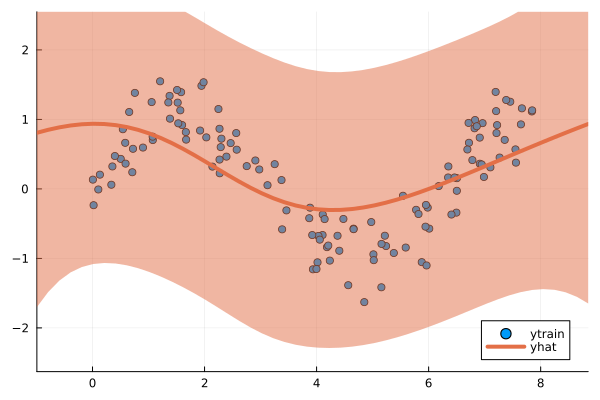

In [81]:
la = Laplace(nn; likelihood=likelihood, λ=λ, subset_of_weights=:all)
fit!(la, data)
plot(la, X, y)

In [65]:
dataloader_128 = DataLoader((X, Y), batchsize=128)

1-element DataLoader(::Tuple{Matrix{Float64}, Matrix{Float64}}, batchsize=128)
  with first element:
  (1×128 Matrix{Float64}, 1×128 Matrix{Float64},)

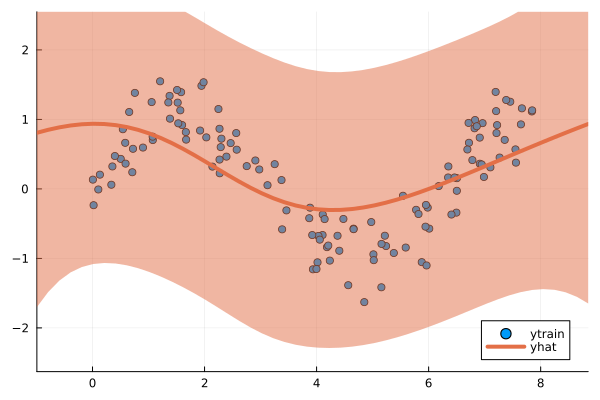

In [82]:
la_b = Laplace(nn; likelihood=likelihood, λ=λ, subset_of_weights=:all)
fit!(la_b, dataloader_128)
plot(la_b, X, y)

In [77]:
isapprox(la_b.H, la.H, atol=.005)

true